In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import  DataLoader
from torchvision import models

import torchvision.transforms as transforms
import torchvision.datasets as dataset

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import cv2 as cv

In [2]:
# modelVGG = models.vgg16(pretrained=True)
# # modelVGG = models.alexnet(pretrained=True)

# print(modelVGG)

In [14]:
modelVGG = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
          nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2, padding=0)          
        )

In [4]:
class UNet(nn.Module):

    def __init__(self, dice=False, in_channels=1, pretrained=False, 
                 num_classes=2, bias=None):

        super().__init__()
        
        if pretrained:
            encoder = models.vgg13(pretrained=True).features
            self.conv1_input = encoder[0] # Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv1 =       encoder[2] # Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv2_input = encoder[5] # Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv2 =       encoder[7] # Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv3_input = encoder[10] # Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv3 =       encoder[12] # Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv4_input = encoder[15] # Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            self.conv4 =       encoder[17] # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

#             self.conv6 =       encoder[17] # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        else:
            self.conv1_input =      nn.Conv2d(in_channels, 64, 3, padding=1)
            self.conv1 =            nn.Conv2d(64, 64, 3, padding=1)
            self.conv2_input =      nn.Conv2d(64, 128, 3, padding=1)
            self.conv2 =            nn.Conv2d(128, 128, 3, padding=1)
            self.conv3_input =      nn.Conv2d(128, 256, 3, padding=1)
            self.conv3 =            nn.Conv2d(256, 256, 3, padding=1)
            self.conv4_input =      nn.Conv2d(256, 512, 3, padding=1)
            self.conv4 =            nn.Conv2d(512, 512, 3, padding=1)
            
#             self.conv6 =            nn.Conv2d(512, 512, 3, padding=1)
        
        self.conv5_input =      nn.Conv2d(512, 1024, 3, padding=1)
        self.conv5 =            nn.Conv2d(1024, 1024, 3, padding=1)

        self.conv6_up =         nn.ConvTranspose2d(1024, 512, 2, 2)
        self.conv6_input =      nn.Conv2d(1024, 512, 3, padding=1)
        self.conv6 =            nn.Conv2d(512, 512, 3, padding=1)
        self.conv7_up =         nn.ConvTranspose2d(512, 256, 2, 2)
        self.conv7_input =      nn.Conv2d(512, 256, 3, padding=1)
        self.conv7 =            nn.Conv2d(256, 256, 3, padding=1)
        self.conv8_up =         nn.ConvTranspose2d(256, 128, 2, 2)
        self.conv8_input =      nn.Conv2d(256, 128, 3, padding=1)
        self.conv8 =            nn.Conv2d(128, 128, 3, padding=1)
        self.conv9_up =         nn.ConvTranspose2d(128, 64, 2, 2)
        self.conv9_input =      nn.Conv2d(128, 64, 3, padding=1)
        self.conv9 =            nn.Conv2d(64, 64, 3, padding=1)
        self.conv9_output =     nn.Conv2d(64, num_classes, 1)

        if dice:
            self.final =        nn.Softmax(dim=1)
        else:
            self.final =        nn.LogSoftmax(dim=1)
            
        if bias:
            nn.init.constant_(self.final, bias)

    def switch(self, dice):

        if dice:
            self.final =        nn.Softmax(dim=1)
        else:
            self.final =        nn.LogSoftmax(dim=1)

    def forward(self, x):

        layer1 = F.relu(self.conv1_input(x))
        layer1 = F.relu(self.conv1(layer1))

        layer2 = F.max_pool2d(layer1, 2)
        layer2 = F.relu(self.conv2_input(layer2))
        layer2 = F.relu(self.conv2(layer2))

        layer3 = F.max_pool2d(layer2, 2)
        layer3 = F.relu(self.conv3_input(layer3))
        layer3 = F.relu(self.conv3(layer3))

        layer4 = F.max_pool2d(layer3, 2)
        layer4 = F.relu(self.conv4_input(layer4))
        layer4 = F.relu(self.conv4(layer4))

        layer5 = F.max_pool2d(layer4, 2)
        layer5 = F.relu(self.conv5_input(layer5))
        layer5 = F.relu(self.conv5(layer5))

        layer6 = F.relu(self.conv6_up(layer5))
        layer6 = torch.cat((layer4, layer6), 1)
        layer6 = F.relu(self.conv6_input(layer6))
        layer6 = F.relu(self.conv6(layer6))

        layer7 = F.relu(self.conv7_up(layer6))
        layer7 = torch.cat((layer3, layer7), 1)
        layer7 = F.relu(self.conv7_input(layer7))
        layer7 = F.relu(self.conv7(layer7))

        layer8 = F.relu(self.conv8_up(layer7))
        layer8 = torch.cat((layer2, layer8), 1)
        layer8 = F.relu(self.conv8_input(layer8))
        layer8 = F.relu(self.conv8(layer8))

        layer9 = F.relu(self.conv9_up(layer8))
        layer9 = torch.cat((layer1, layer9), 1)
        layer9 = F.relu(self.conv9_input(layer9))
        layer9 = F.relu(self.conv9(layer9))
#         layer9 = self.final(self.conv9_output(layer9))
        layer9 = self.conv9_output(layer9)

        return layer9
    
    def get_bottleneck_feature_map(self, x):
        layer1 = F.relu(self.conv1_input(x))
        layer1 = F.relu(self.conv1(layer1))

        layer2 = F.max_pool2d(layer1, 2)
        layer2 = F.relu(self.conv2_input(layer2))
        layer2 = F.relu(self.conv2(layer2))

        layer3 = F.max_pool2d(layer2, 2)
        layer3 = F.relu(self.conv3_input(layer3))
        layer3 = F.relu(self.conv3(layer3))

        layer4 = F.max_pool2d(layer3, 2)
        layer4 = F.relu(self.conv4_input(layer4))
        layer4 = F.relu(self.conv4(layer4))

        layer5 = F.max_pool2d(layer4, 2)
        layer5 = F.relu(self.conv5_input(layer5))
        layer5 = F.relu(self.conv5(layer5))
        
        return layer5
    
    def get_bottleneck_architecture(self):
        return nn.Sequential(self.conv1_input,
                             nn.ReLU(),
                             self.conv1,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv2_input,
                             nn.ReLU(),
                             self.conv2,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv3_input,
                             nn.ReLU(),
                             self.conv3,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv4_input,
                             nn.ReLU(),
                             self.conv4,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv5_input,
                             nn.ReLU(),
                             self.conv5,
                             nn.ReLU()
        )
    
    def get_features(self):
        return nn.Sequential(self.conv1_input,
                             nn.ReLU(),
                             self.conv1,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv2_input,
                             nn.ReLU(),
                             self.conv2,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv3_input,
                             nn.ReLU(),
                             self.conv3,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv4_input,
                             nn.ReLU(),
                             self.conv4,
                             nn.ReLU(),
                             nn.MaxPool2d(2),
                             self.conv5_input,
                             nn.ReLU(),
                             self.conv5,
                             nn.ReLU(),
                             self.conv6_up,
                             nn.ReLU(),
                             self.conv6_input,
                             self.conv6,
                             self.conv7_up,
                             self.conv7_input,
                             self.conv7,
                             self.conv8_up,
                             self.conv8_input,
                             self.conv8,
                             self.conv9_up,
                             self.conv9_input,
                             self.conv9,
                             self.conv9_output,
                             self.final
        )
    
def set_weights_to_ones(model):
    for i, layer in enumerate(model):
        if type(layer) == nn.Conv2d:
            model[i].weight = nn.Parameter(torch.ones(layer.weight.shape))
    return model

In [5]:
unet = UNet(in_channels=3)
model = unet.get_bottleneck_architecture()

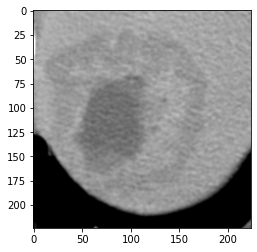

In [6]:
im=cv.imread("/kaggle/input/comp766/input_image_tumor.PNG")
im=cv.cvtColor(im,cv.COLOR_BGR2RGB)
im=cv.resize(im,(224,224))
plt.imshow(im)
plt.show()
img = im.copy()

In [7]:
transform = transforms.Compose([
    transforms.ToPILImage(),
#     transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img=np.array(img)
img=transform(img)
img=img.unsqueeze(0)
print(img.size())

torch.Size([1, 3, 224, 224])


In [9]:
def count_layers(model):
    """
    Count the number of maxpooling or conv layers in a feature extractor
    """
    no_of_layers=0
    conv_layers=[]
    kernel_size = []
    stride = []
    padding = []

    model_children=list(model.children())

    for child in model_children:
    #     if type(child)==nn.Conv2d:
        if type(child)==nn.Conv2d or type(child)==nn.MaxPool2d:
            no_of_layers+=1
            conv_layers.append(child)
            if type(child)==nn.Conv2d:
                kernel_size.append(child.kernel_size)
                stride.append(child.stride)
                padding.append(child.padding)
            else:
                kernel_size.append((child.kernel_size,child.kernel_size))
                stride.append((child.stride,child.stride))
                padding.append((child.padding,child.padding))
        elif type(child)==nn.Sequential:
            for layer in child.children():
    #             if type(layer)==nn.Conv2d:
                if type(layer)==nn.Conv2d or type(layer)==nn.MaxPool2d:
                    no_of_layers+=1
                    conv_layers.append(layer)
                    if type(layer)==nn.Conv2d:
                        kernel_size.append(layer.kernel_size)
                        stride.append(layer.stride)
                        padding.append(layer.padding)
                    else:
                        kernel_size.append((layer.kernel_size,layer.kernel_size))
                        stride.append((layer.stride,layer.stride))
                        padding.append((layer.padding,layer.padding))
    print('Total number of conv & maxpooling layers is:', no_of_layers)
    return no_of_layers, kernel_size, stride, padding

In [10]:
def compute_coordinates(pixel, model, img, flag='feature'):
    """
    Args:
        pixel: a pixel location on the input image
        model: a feature extractor
        img: the original image
        flag: take 'feature' or 'input' as input to determine 
                whether the input pixel coordinates come from the input image (i.e. receptive field) 
                or the feature map

    Returns:
      coord: the center coordinates of the receptive field OR a pixel location on the feature map
      r0: receptive field size
      viz: feature maps
    """
    
    if flag != 'feature' and flag != 'input':
        raise ValueError("Argument 'image' must take 'feature' or 'input' as input")
        
    pixel = np.asarray(pixel)
    coords = [0,0] # pixel coordinate [centerx, centery] to return
    
    S0 = [1,1] # initialize S0
    P0 = [0,0] # initialize P0
    r0 = [1,1] # initialize receptive field size
    
    L, kernel_size, stride, padding = count_layers(model)
    for axis in range(2):
        for layer in range(0,L):
            S0[axis] = S0[axis]*stride[layer][axis]

            tmp_s = 1 # initialize temporary stride used for computing P
            for tmp_layer in range(0,layer):
                tmp_s = tmp_s*stride[tmp_layer][axis]

            P0[axis] = P0[axis] + padding[layer][axis]*tmp_s
            r0[axis] = r0[axis] + (kernel_size[layer][axis] - 1)*tmp_s
        
        r0[axis] = r0[axis] + 1
        
        if flag == 'feature':
            coords[axis] = -P0[axis] + pixel[axis] * S0[axis] + (r0[axis] - 1)/2  
        elif flag == 'input':
            coords[axis] = (pixel[axis] + P0[axis] + (1 - r0[axis]) / 2) / S0[axis]

    outputs = model(img)
    viz = outputs[0,:,:,:].data
    fm_size = len(viz[1])
    print('Size of the feature map is:', fm_size)
    
    if coords[0] < 0 or coords[1] < 0 or coords[0] >= fm_size or coords[1] >= fm_size:
        raise ValueError("The pixel coordinates on the feature map are out of bound")
    return coords, r0, viz


In [18]:
in_coords = [50,42]
flag = 'input'# 'input' or 'feature'
out_coords, rf_size, viz = compute_coordinates(in_coords, modelVGG, img, flag) # pixel coordinates on receptive field
                                                                            # replace "model" with "modelVGG" to see 
                                                                            # the results from a shallower network
print(out_coords)
print(rf_size)

Total number of conv & maxpooling layers is: 6
Size of the feature map is: 56
[12.0, 10.0]
[17, 17]


In [19]:
if flag == 'input':
    rf_coords = in_coords
    fm_coords = out_coords

elif flag == 'feature':
    fm_coords = in_coords
    rf_coords = out_coords

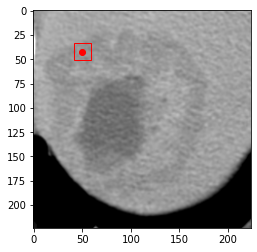

In [20]:
# Create figure and axes
fig, ax = plt.subplots()
# Display the image
ax.imshow(im, cmap='gray')
ax.plot(rf_coords[0], rf_coords[1], 'ro')
# Create a Rectangle patch
rect = patches.Rectangle((rf_coords[0] - 0.5*rf_size[0], rf_coords[1] - 0.5*rf_size[1]), rf_size[0], rf_size[1], linewidth=1, edgecolor='r', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

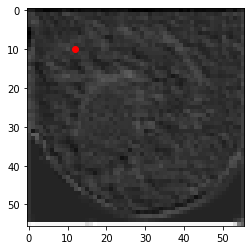

In [25]:
plt.imshow(viz[10],cmap='gray') # change the index of 'viz' to get different feature map
plt.plot(fm_coords[0], fm_coords[1], 'ro')

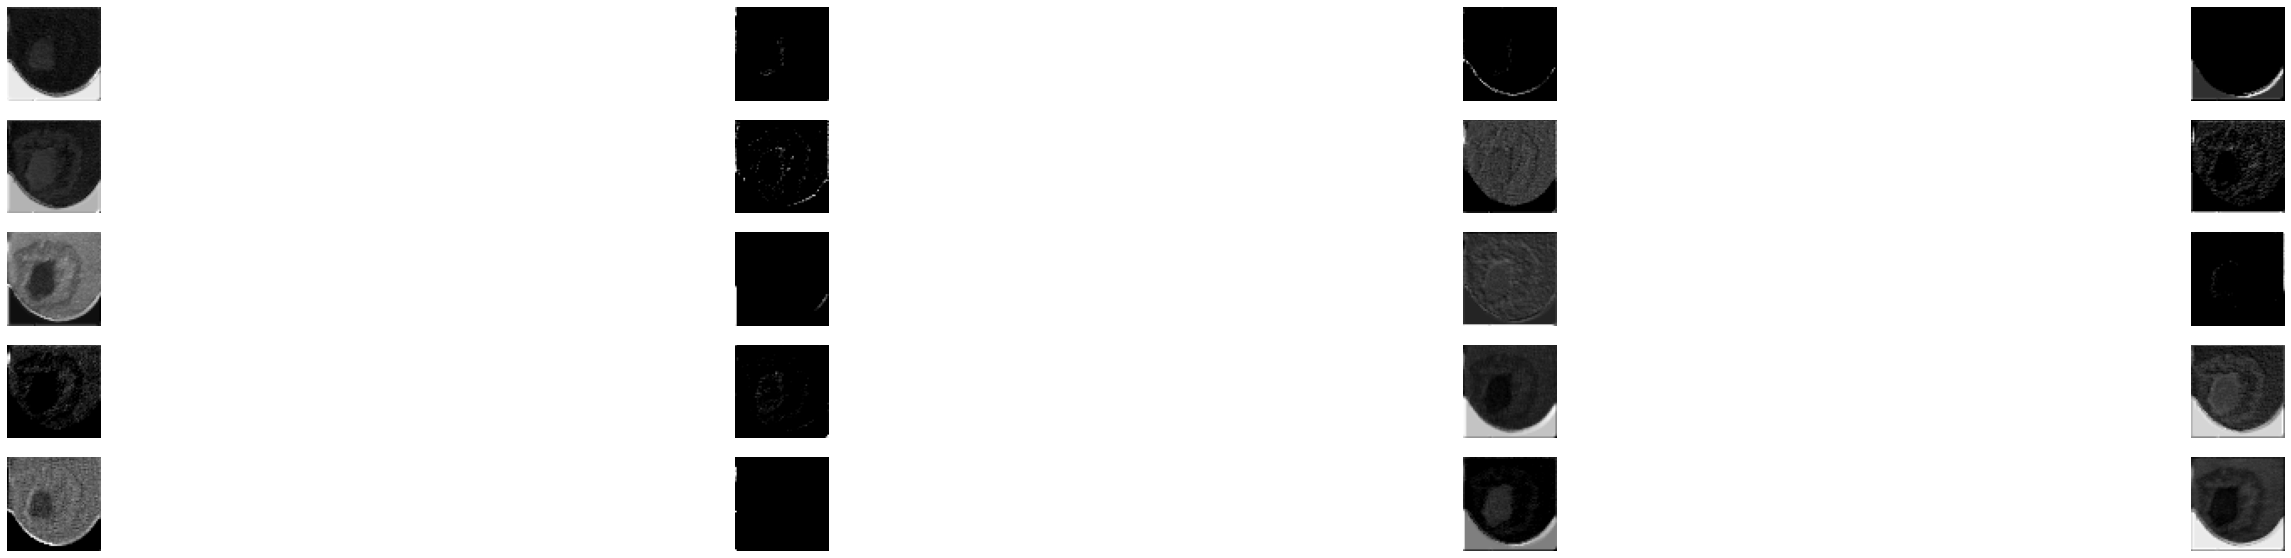

In [29]:
# outputs = unet.get_bottleneck_feature_map(img)
outputs = modelVGG(img)
viz = outputs[0,:,:,:].data
fm_size = len(viz[1])

plt.figure(figsize=(50, 10))
for i, filter in enumerate(viz):
    if i == 20: 
        break
    plt.subplot(5, 4, i + 1)
    plt.imshow(filter, cmap='gray')
    plt.axis("off")